# 2D potential toy model: Double well

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0,'..')

Import code of BG

In [3]:
from boltzmann_generator import BoltzmannGenerator
from analysis import *
import energy_models.toy_2d_potentials as toy_2d_potentials
double_well = toy_2d_potentials.DoubleWell()

In [4]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16, 'savefig.dpi': 300, 'savefig.bbox': 'tight'})
results_dir = "../results/double_well/"

## Plotting scripts
Taken unchanged from BG article

In [5]:
def plot_potential(cbar=True, orientation='vertical', figsize=(6, 8)):
    # 2D potential
    xgrid = np.linspace(-3, 3, 100)
    ygrid = np.linspace(-7, 7, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    E = double_well.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=4)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.5, 7.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            #cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
    plt.xticks([-2, 0, 2])
    plt.yticks([-5, 0, 5])
    plt.xlabel('$x_1$', labelpad=0)
    plt.ylabel('$x_2$', labelpad=-10)

In [6]:
# Calculate free energy profile with reveighted PDF
def test_sample_rew(network, temperature=1.0, plot=True):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(n_sample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], 100, (-2.5, 2.5), log_weights=log_w)
    plt.figure(figsize=(4, 4))
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    if plot:
        double_well.plot_dimer_energy()
        plt.errorbar(bin_means, Emean, Estd, linewidth=2, color='green')
    # variance
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [7]:
def hist_weights(network):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(n_sample=100000)
    log_w -= log_w.max()
    bins = np.linspace(-2.5, 2.5, 100)
    bin_means = 0.5 * (bins[:-1] + bins[1:])
    sample_x_index = np.digitize(sample_x[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_w)):
        whist[sample_x_index[i]] += np.exp(log_w[i])
    return bin_means, whist[1:-1]

In [8]:
# Calculate free energy profile with generated PDF without reweighting
def test_sample(network, n_sample=100000, temperature=1.0, plot=True):
    if n_sample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(n_sample=n_sample)
    else:
        sample_x = []
        for i in range(int(n_sample/100000)):
            _, sample_x_, _, _, _ = network.sample(n_sample=n_sample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100)
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature)
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

In [9]:
# Plot 
# 1.) x training data
# 2.) map them through Fxz(x) and plot obtained z points
# 3.) computed free energy profile, when PDF obtained by BG is not reweighted
# 4.) the same as 3.) with reweighting

def plot_network(network, save_as="", weight_cutoff=1e-2):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3.5))
    plt.subplots_adjust(wspace=0.25)
    
    # Plot X distribution
    axis = axes[0]
    axis.plot(traj_left[:, 0], traj_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(x_ts[:, 0], x_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(traj_right[:, 0], traj_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    axis.set_xlabel('$x_1$')
    axis.set_xlim(-3, 3)
    axis.set_ylabel('$x_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    
    # Plot Z distribution
    axis = axes[1]
    z_left = network.transform_xz(traj_left)
    z_ts = network.transform_xz(x_ts)
    z_right = network.transform_xz(traj_right)
    axis.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=3, color='blue')
    axis.plot(z_ts[:, 0], z_ts[:, 1], linewidth=0, marker='.', markersize=3, color='orange')
    axis.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=3, color='red')
    circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
    axis.add_artist(circle)
    axis.set_xlabel('$z_1$')
    axis.set_xlim(-4, 4)
    axis.set_ylabel('$z_2$', labelpad=-12)
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    
    # Plot proposal distribution
    X1, Y1 = test_sample(network, temperature=1.0, plot=False);
    _, W1 = hist_weights(network)
    axis = axes[2]
    Ex, E = double_well.plot_dimer_energy(axis=axis, temperature=1.0)
    Y1 = Y1 - Y1.min() + E.min()
    Inan = np.where(W1 < weight_cutoff)
    Y1[Inan] = np.nan
    axis.plot(X1, Y1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([])
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('Free energy / kT')
    
    # Plot reweighted distribution
    RX1, RY1, DR1 = test_sample_rew(network, temperature=1.0, plot=False);
    axis = axes[3]
    Ex, E = double_well.plot_dimer_energy(axis=axis, temperature=1.0)
    RY1 = RY1 - RY1[np.isfinite(RY1)].min() + E.min()
    RY1[Inan] = np.nan
    axis.errorbar(RX1, RY1, DR1, color='orange', linewidth=2, label='ML+KL')
    axis.set_xlim(-3, 3)
    axis.set_ylim(-12, 5.5)
    axis.set_yticks([-12, -10, -8, -6, -4, -2, 0, 2, 4])
    axis.set_xlabel('$x_1$')
    axis.set_ylabel('')
    
    if save_as:
        fig.savefig(results_dir + save_as)

## Landscape of potential

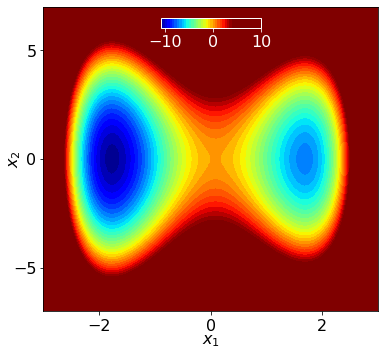

In [10]:
plot_potential(cbar=True, orientation='horizontal')
plt.savefig(results_dir + "potential_landscape.png")

## Create training and validation datasets
- Markov chain Monte Carlo (MCMC) is used
- 10 000 steps for both right and left metastable state
- every 10th configuration is saved
- the same for validation dataset

This way by merging data for left and right metastable states we obtain 2000 samples in both training and validation datasets. 

In [11]:
from sampling import MetropolisGauss

In [12]:
nsteps = 10000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, sigma_metro=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.trajectory.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.trajectory.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.trajectory.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.trajectory.copy()

We also produce a set of states with $x_1 = 0$.
It will not be used in training. Only in analysis in order to visualize "border" between left and right state.

In [13]:
x_ts = np.vstack([np.zeros(1000), (1.0/double_well.params['d']) * np.random.randn(1000)]).T

### Plot training datasatet together with "boundary" states

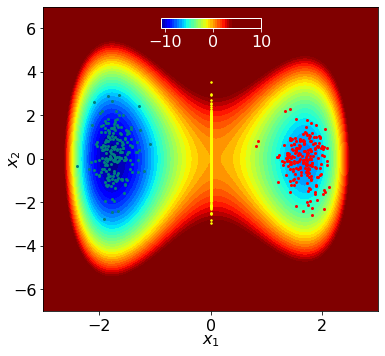

In [14]:
plot_potential(cbar=True, orientation='horizontal')
plt.plot(traj_left[::5, 0], traj_left[::5, 1], linewidth=0, marker='.', markersize=4, color='teal')
plt.plot(x_ts[:, 0], x_ts[:, 1], linewidth=0, marker='.', markersize=3, color='yellow')
plt.plot(traj_right[::5, 0], traj_right[::5, 1], linewidth=0, marker='.', markersize=4, color='red')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.yticks([-6, -4, -2, 0, 2, 4, 6]);
plt.savefig(results_dir + "training_dataset.png")

## Preparation for training
### Parameters of the Boltzmann generators
We will always use the same BG parameters. We will only change method of training.
All our BGs will have 5 Real NVP layers.

In [15]:
bg_params = {
    "layers": 'R' * 4, 
    "energy_model": double_well,
    "nl_layers": 2
}

### Merge left and right training/validation datasets and define RC
$x_1$ is going to be used as reaction coordinate (RC).

In [16]:
training_dataset = np.vstack([traj_left, traj_right])
validation_dataset = np.vstack([traj_left_val, traj_right_val])


def get_x(x):
    return x[:, 0]

rc_loss_params = {
    "rc_function": get_x,
    "rc_min": -2.5,
    "rc_max": 2.5,
}

### Training script and script for latent interpolation

In [17]:
def train_bg(training_schedule, save_as=""):
    for i, args in enumerate(training_shedule):
        input("Should training continue? (press Enter)")
        current_loss_vals = bg.train(
            training_dataset,
            x_val = validation_dataset,
            weight_ML = args[0],
            weight_KL = args[1],
            weight_RCEnt = args[2],
            iterations = args[3],
            batch_size = args[4],
            lr = args[5],
            print_total_loss_only = True,
            **rc_loss_params
        )
        
        plt.plot(current_loss_vals["loss"], label="Train. loss")
        plt.plot(current_loss_vals["val_loss"], label="Val. loss")
        
        plt.legend(loc='upper right')
        if save_as:
            plt.savefig(results_dir + save_as +f"{i}.png")
        plt.show()
    

In [18]:
def latent_interpolation(bg, x1, x2, nstep=1000):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

def plot_latent_interpolation(bg, save_as=""):
    xpaths = []
    for i in range(10):
        x1 = traj_left[np.random.randint(1000)] 
        x2 = traj_right[np.random.randint(1000)]
        xpaths.append(latent_interpolation(bg, x1, x2, nstep=1000))
        
    plot_potential(cbar=False, figsize=(5, 5))
    plt.xticks([])
    plt.xlabel('')
    plt.yticks([])
    plt.ylabel('')
    for xpath in xpaths:
        plt.plot(xpath[:, 0], xpath[:, 1], linewidth=2, color='white')
    if save_as:
        plt.tight_layout()
        plt.savefig(save_as, dpi=300)

## Testing models with different training schedules
- ML loss = training by example
- KL loss = training by energy
- RC loss = training by increasing RC entropy

All scenarios start with 200 training iterations using solely ML.
After that, 400 steps is used using the method in the title.

In order to evaluate model 4 graphs are plotted:
- distribution of training data in $x$ together with "border" states (same for all models)
- mapping of these points to $z$ (prior) space of BG
- free energy profile obtained as $-kT \ln (p(x_1))$ where $p(x_1)$ is PDF produced by BG
- free energy profiled obtained when $p(x)$ is reweighted using weights $w(x) = e^{-u(x)}/p(x)$ (see the article)

For some of the models, we plot a so called latent interpolation as well:
- 10 pairs consisting of one state in right part and one state in left part of metastable states
- they are mapped to latent ($z$) space, where a linear interpolation is done
- this interpolating lines are mapped back to $x$, the result can be seen asi white lines

### Training by ML

In [19]:
bg = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [20]:
                    # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1, 0,  0,  200,  500,  1e-3],
                    [1, 0,  0,  400,  2000, 1e-3]]

Should training continue? (press Enter)
Iteration 0/200: loss: 1.88 val_loss: 1.84 
Iteration 10/200: loss: 1.54 val_loss: 1.45 
Iteration 20/200: loss: 1.22 val_loss: 1.07 
Iteration 30/200: loss: 0.91 val_loss: 0.98 
Iteration 40/200: loss: 0.64 val_loss: 0.61 
Iteration 50/200: loss: 0.55 val_loss: 0.51 
Iteration 60/200: loss: 0.55 val_loss: 0.39 
Iteration 70/200: loss: 0.29 val_loss: 0.34 
Iteration 80/200: loss: 0.28 val_loss: 0.25 
Iteration 90/200: loss: 0.29 val_loss: 0.31 
Iteration 100/200: loss: 0.26 val_loss: 0.20 
Iteration 110/200: loss: 0.16 val_loss: 0.17 
Iteration 120/200: loss: 0.12 val_loss: 0.06 
Iteration 130/200: loss: 0.18 val_loss: 0.01 
Iteration 140/200: loss: 0.15 val_loss: 0.16 
Iteration 150/200: loss: 0.27 val_loss: 0.17 
Iteration 160/200: loss: 0.19 val_loss: 0.12 
Iteration 170/200: loss: 0.11 val_loss: 0.08 
Iteration 180/200: loss: 0.13 val_loss: 0.19 
Iteration 190/200: loss: 0.07 val_loss: 0.08 


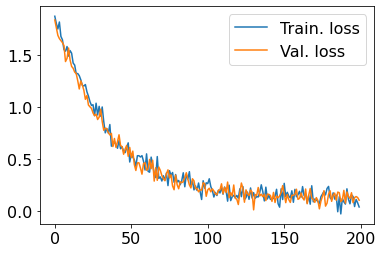

Should training continue? (press Enter)
Iteration 0/400: loss: 0.10 val_loss: 0.16 
Iteration 10/400: loss: 0.27 val_loss: 0.17 
Iteration 20/400: loss: 0.16 val_loss: 0.16 
Iteration 30/400: loss: 0.10 val_loss: 0.13 
Iteration 40/400: loss: 0.16 val_loss: 0.11 
Iteration 50/400: loss: 0.11 val_loss: 0.16 
Iteration 60/400: loss: 0.11 val_loss: 0.06 
Iteration 70/400: loss: 0.11 val_loss: 0.10 
Iteration 80/400: loss: 0.08 val_loss: 0.14 
Iteration 90/400: loss: 0.08 val_loss: 0.02 
Iteration 100/400: loss: 0.06 val_loss: 0.08 
Iteration 110/400: loss: 0.08 val_loss: 0.06 
Iteration 120/400: loss: 0.10 val_loss: 0.09 
Iteration 130/400: loss: 0.14 val_loss: 0.07 
Iteration 140/400: loss: 0.08 val_loss: 0.07 
Iteration 150/400: loss: 0.14 val_loss: 0.08 
Iteration 160/400: loss: 0.06 val_loss: 0.04 
Iteration 170/400: loss: 0.07 val_loss: 0.08 
Iteration 180/400: loss: 0.05 val_loss: 0.04 
Iteration 190/400: loss: 0.09 val_loss: 0.09 
Iteration 200/400: loss: 0.02 val_loss: 0.06 
Itera

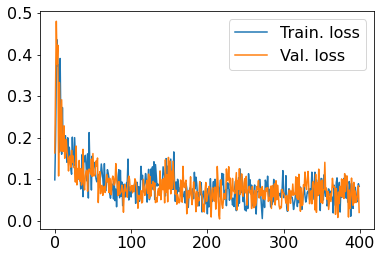

In [21]:
train_bg(bg)

<ipython-input-8-bdbb96c924d2>:15: RuntimeWarning: divide by zero encountered in log
  Eh = -np.log(h) / temperature
../analysis.py:116: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


Estimator Standard Error:  0.7246866663247624


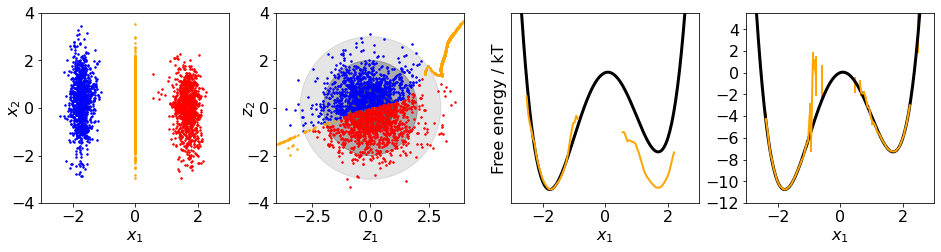

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [22]:
plot_network(bg, "trained_with_ML.png")

### Training by KL

In [23]:
bg = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [24]:
                    # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1, 0,  0,  200,  500,  1e-3],
                    [0, 1,  0,  400,  2000, 1e-3]]

Should training continue? (press Enter)
Iteration 0/200: loss: 1.86 val_loss: 1.83 
Iteration 10/200: loss: 1.58 val_loss: 1.46 
Iteration 20/200: loss: 1.43 val_loss: 1.41 
Iteration 30/200: loss: 1.23 val_loss: 1.26 
Iteration 40/200: loss: 0.83 val_loss: 0.78 
Iteration 50/200: loss: 0.48 val_loss: 0.46 
Iteration 60/200: loss: 0.40 val_loss: 0.45 
Iteration 70/200: loss: 0.27 val_loss: 0.22 
Iteration 80/200: loss: 0.25 val_loss: 0.11 
Iteration 90/200: loss: 0.28 val_loss: 0.33 
Iteration 100/200: loss: 0.24 val_loss: 0.26 
Iteration 110/200: loss: 0.21 val_loss: 0.13 
Iteration 120/200: loss: 0.21 val_loss: 0.24 
Iteration 130/200: loss: 0.21 val_loss: 0.26 
Iteration 140/200: loss: 0.17 val_loss: 0.20 
Iteration 150/200: loss: 0.12 val_loss: 0.19 
Iteration 160/200: loss: 0.06 val_loss: 0.12 
Iteration 170/200: loss: 0.06 val_loss: 0.11 
Iteration 180/200: loss: 0.12 val_loss: 0.08 
Iteration 190/200: loss: 0.15 val_loss: 0.10 


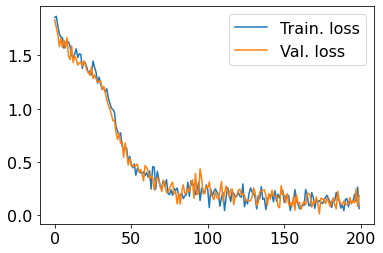

Should training continue? (press Enter)
Iteration 0/400: loss: -6.97 val_loss: -6.86 
Iteration 10/400: loss: -7.29 val_loss: -7.25 
Iteration 20/400: loss: -7.80 val_loss: -7.83 
Iteration 30/400: loss: -8.07 val_loss: -8.09 
Iteration 40/400: loss: -8.12 val_loss: -8.08 
Iteration 50/400: loss: -8.14 val_loss: -8.15 
Iteration 60/400: loss: -8.11 val_loss: -8.06 
Iteration 70/400: loss: -8.11 val_loss: -8.08 
Iteration 80/400: loss: -8.02 val_loss: -7.98 
Iteration 90/400: loss: -8.04 val_loss: -8.04 
Iteration 100/400: loss: -8.10 val_loss: -8.09 
Iteration 110/400: loss: -8.17 val_loss: -8.12 
Iteration 120/400: loss: -8.15 val_loss: -8.14 
Iteration 130/400: loss: -8.10 val_loss: -8.13 
Iteration 140/400: loss: -8.14 val_loss: -8.11 
Iteration 150/400: loss: -8.17 val_loss: -8.17 
Iteration 160/400: loss: -8.17 val_loss: -8.14 
Iteration 170/400: loss: -8.16 val_loss: -8.10 
Iteration 180/400: loss: -8.13 val_loss: -8.13 
Iteration 190/400: loss: -8.12 val_loss: -8.13 
Iteration 2

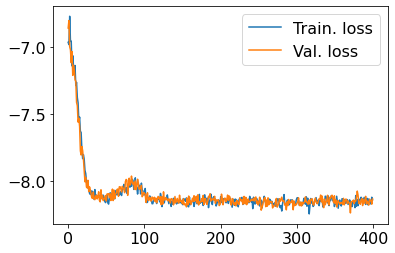

In [25]:
res = train_bg(training_shedule)

<ipython-input-8-bdbb96c924d2>:15: RuntimeWarning: divide by zero encountered in log
  Eh = -np.log(h) / temperature
../analysis.py:116: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


Estimator Standard Error:  0.6044183979642427


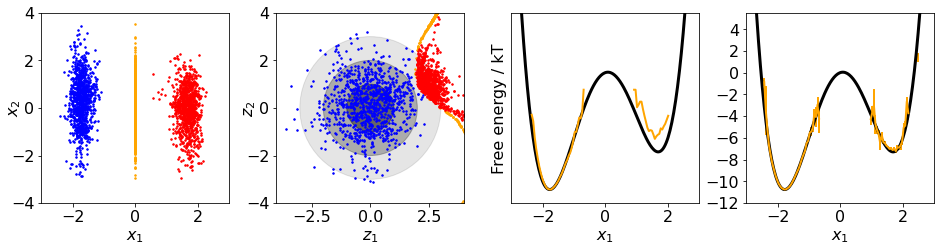

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [26]:
plot_network(bg, "trained_with_KL.png")

### Training by ML + KL

In [27]:
bg = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [28]:
                    # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1, 0,  0,  200,  500,  1e-3],
                    [1, 1,  0,  400,  2000, 1e-3]]

Should training continue? (press Enter)
Iteration 0/200: loss: 2.03 val_loss: 1.89 
Iteration 10/200: loss: 1.61 val_loss: 1.60 
Iteration 20/200: loss: 1.47 val_loss: 1.47 
Iteration 30/200: loss: 1.29 val_loss: 1.24 
Iteration 40/200: loss: 1.07 val_loss: 1.16 
Iteration 50/200: loss: 0.87 val_loss: 0.79 
Iteration 60/200: loss: 0.56 val_loss: 0.56 
Iteration 70/200: loss: 0.46 val_loss: 0.28 
Iteration 80/200: loss: 0.32 val_loss: 0.27 
Iteration 90/200: loss: 0.31 val_loss: 0.15 
Iteration 100/200: loss: 0.18 val_loss: 0.20 
Iteration 110/200: loss: 0.14 val_loss: 0.22 
Iteration 120/200: loss: 0.17 val_loss: 0.17 
Iteration 130/200: loss: 0.20 val_loss: 0.04 
Iteration 140/200: loss: 0.18 val_loss: 0.07 
Iteration 150/200: loss: 0.13 val_loss: 0.17 
Iteration 160/200: loss: 0.21 val_loss: 0.03 
Iteration 170/200: loss: 0.08 val_loss: 0.17 
Iteration 180/200: loss: 0.18 val_loss: 0.07 
Iteration 190/200: loss: 0.06 val_loss: 0.02 


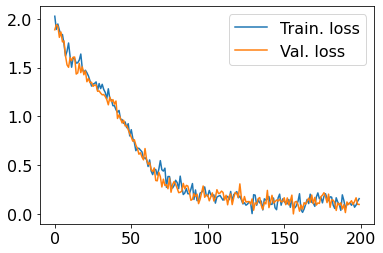

Should training continue? (press Enter)
Iteration 0/400: loss: -6.76 val_loss: -5.99 
Iteration 10/400: loss: -7.04 val_loss: -6.91 
Iteration 20/400: loss: -7.54 val_loss: -7.33 
Iteration 30/400: loss: -7.41 val_loss: -7.50 
Iteration 40/400: loss: -7.54 val_loss: -7.60 
Iteration 50/400: loss: -7.48 val_loss: -7.51 
Iteration 60/400: loss: -7.59 val_loss: -7.55 
Iteration 70/400: loss: -7.57 val_loss: -7.54 
Iteration 80/400: loss: -7.48 val_loss: -7.47 
Iteration 90/400: loss: -7.55 val_loss: -7.52 
Iteration 100/400: loss: -7.59 val_loss: -7.58 
Iteration 110/400: loss: -7.51 val_loss: -7.52 
Iteration 120/400: loss: -7.56 val_loss: -7.63 
Iteration 130/400: loss: -7.47 val_loss: -7.50 
Iteration 140/400: loss: -7.55 val_loss: -7.56 
Iteration 150/400: loss: -7.46 val_loss: -7.51 
Iteration 160/400: loss: -7.57 val_loss: -7.64 
Iteration 170/400: loss: -7.53 val_loss: -7.57 
Iteration 180/400: loss: -7.61 val_loss: -7.65 
Iteration 190/400: loss: -7.57 val_loss: -7.61 
Iteration 2

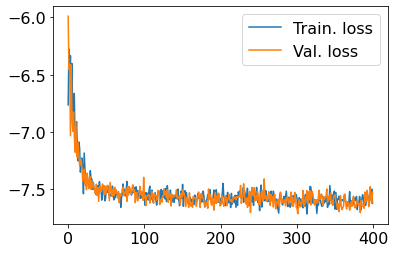

In [29]:
train_bg(training_shedule)

<ipython-input-8-bdbb96c924d2>:15: RuntimeWarning: divide by zero encountered in log
  Eh = -np.log(h) / temperature
../analysis.py:116: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


Estimator Standard Error:  0.7797091607854838


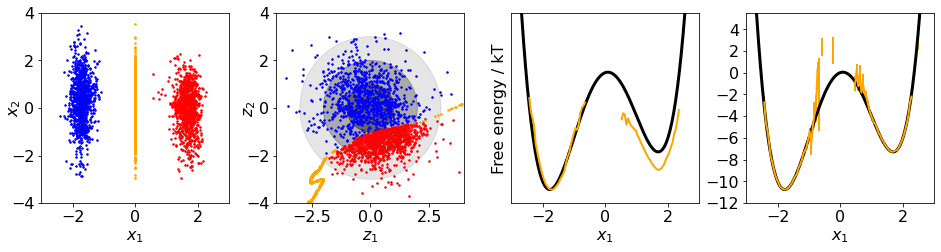

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [30]:
plot_network(bg, "trained_with_ML_KL.png")

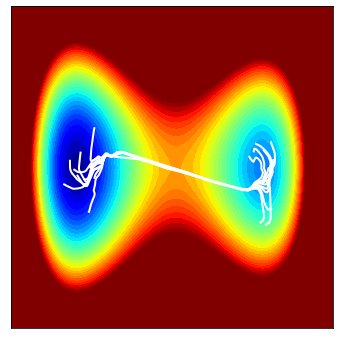

In [31]:
plot_latent_interpolation(bg, "latent_interpolation_without_RC.png")

### Training by ML + KL + RC

In [55]:
bg = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [56]:
                # w_ML,  w_KL, w_RC, iter, b_size, lr
training_shedule = [[1,    0,  0,  200, 500,  1e-3],
                    [1,    1,  1,  200, 2000, 1e-3],
                    [0.01, 1,  5,  200, 2000, 1e-3]]

Should training continue? (press Enter)
Iteration 0/200: loss: 1.98 val_loss: 1.90 
Iteration 10/200: loss: 1.55 val_loss: 1.57 
Iteration 20/200: loss: 1.39 val_loss: 1.37 
Iteration 30/200: loss: 1.26 val_loss: 1.31 
Iteration 40/200: loss: 0.88 val_loss: 0.93 
Iteration 50/200: loss: 0.57 val_loss: 0.63 
Iteration 60/200: loss: 0.54 val_loss: 0.51 
Iteration 70/200: loss: 0.37 val_loss: 0.36 
Iteration 80/200: loss: 0.26 val_loss: 0.20 
Iteration 90/200: loss: 0.22 val_loss: 0.36 
Iteration 100/200: loss: 0.18 val_loss: 0.30 
Iteration 110/200: loss: 0.14 val_loss: 0.08 
Iteration 120/200: loss: 0.15 val_loss: 0.24 
Iteration 130/200: loss: 0.18 val_loss: 0.23 
Iteration 140/200: loss: 0.17 val_loss: 0.15 
Iteration 150/200: loss: 0.12 val_loss: 0.10 
Iteration 160/200: loss: 0.11 val_loss: 0.23 
Iteration 170/200: loss: 0.15 val_loss: 0.18 
Iteration 180/200: loss: 0.13 val_loss: 0.16 
Iteration 190/200: loss: 0.19 val_loss: 0.12 


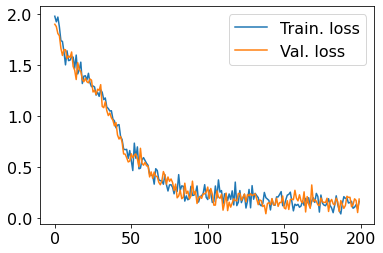

Should training continue? (press Enter)
Iteration 0/200: loss: -8.88 val_loss: -8.02 
Iteration 10/200: loss: -8.99 val_loss: -8.94 
Iteration 20/200: loss: -9.15 val_loss: -9.06 
Iteration 30/200: loss: -9.30 val_loss: -9.38 
Iteration 40/200: loss: -9.38 val_loss: -9.33 
Iteration 50/200: loss: -9.38 val_loss: -9.42 
Iteration 60/200: loss: -9.43 val_loss: -9.45 
Iteration 70/200: loss: -9.45 val_loss: -9.45 
Iteration 80/200: loss: -9.51 val_loss: -9.40 
Iteration 90/200: loss: -9.46 val_loss: -9.46 
Iteration 100/200: loss: -9.45 val_loss: -9.49 
Iteration 110/200: loss: -9.45 val_loss: -9.46 
Iteration 120/200: loss: -9.35 val_loss: -9.43 
Iteration 130/200: loss: -9.42 val_loss: -9.47 
Iteration 140/200: loss: -9.46 val_loss: -9.47 
Iteration 150/200: loss: -9.48 val_loss: -9.49 
Iteration 160/200: loss: -9.52 val_loss: -9.49 
Iteration 170/200: loss: -9.49 val_loss: -9.50 
Iteration 180/200: loss: -9.44 val_loss: -9.47 
Iteration 190/200: loss: -9.50 val_loss: -9.52 


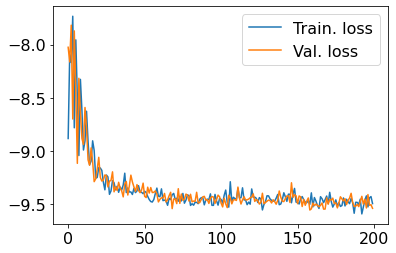

Should training continue? (press Enter)
Iteration 0/200: loss: -17.68 val_loss: -17.65 
Iteration 10/200: loss: -17.84 val_loss: -17.89 
Iteration 20/200: loss: -17.93 val_loss: -17.95 
Iteration 30/200: loss: -17.96 val_loss: -17.98 
Iteration 40/200: loss: -17.99 val_loss: -18.01 
Iteration 50/200: loss: -18.06 val_loss: -18.01 
Iteration 60/200: loss: -18.02 val_loss: -18.05 
Iteration 70/200: loss: -18.04 val_loss: -18.02 
Iteration 80/200: loss: -18.04 val_loss: -18.06 
Iteration 90/200: loss: -18.03 val_loss: -18.02 
Iteration 100/200: loss: -17.95 val_loss: -18.01 
Iteration 110/200: loss: -18.04 val_loss: -18.03 
Iteration 120/200: loss: -18.06 val_loss: -18.00 
Iteration 130/200: loss: -18.01 val_loss: -18.05 
Iteration 140/200: loss: -18.10 val_loss: -18.06 
Iteration 150/200: loss: -18.08 val_loss: -18.04 
Iteration 160/200: loss: -18.09 val_loss: -18.03 
Iteration 170/200: loss: -18.08 val_loss: -18.03 
Iteration 180/200: loss: -18.07 val_loss: -18.05 
Iteration 190/200: lo

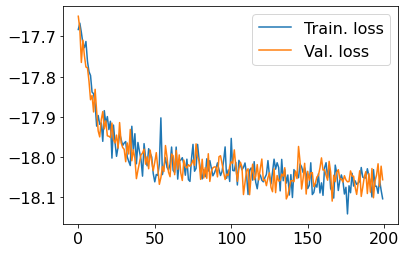

<Figure size 432x288 with 0 Axes>

In [57]:
train_bg(training_shedule, save_as="loss_with_RC_")

<ipython-input-8-bdbb96c924d2>:15: RuntimeWarning: divide by zero encountered in log
  Eh = -np.log(h) / temperature


Estimator Standard Error:  0.1526330964202188


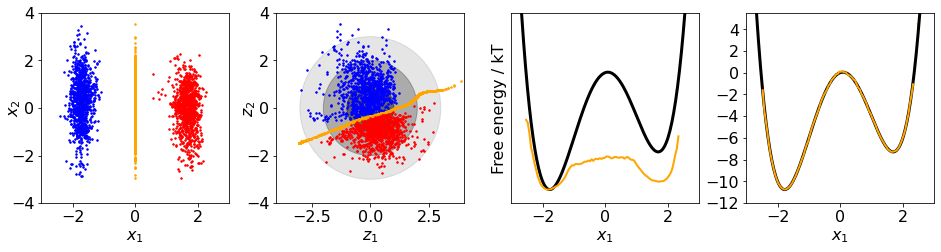

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [58]:
plot_network(bg, "trained_with_ML_KL_RC.png")

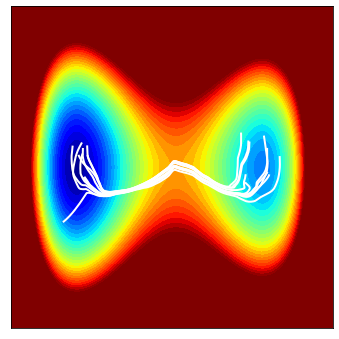

In [59]:
plot_latent_interpolation(bg, "latent_interpolation_with_RC.png")

### Training by ML + KL + (aggressive RC)

In [68]:
bg = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [69]:
                    # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1,    0,  0,  200,  500,  1e-3],
                    [0.01, 1,  3,  200,  2000, 1e-3],
                    [0.01, 1,  10, 200,  2000, 1e-3]]

Should training continue? (press Enter)
Iteration 0/200: loss: 1.95 val_loss: 1.89 
Iteration 10/200: loss: 1.50 val_loss: 1.47 
Iteration 20/200: loss: 1.40 val_loss: 1.38 
Iteration 30/200: loss: 1.36 val_loss: 1.30 
Iteration 40/200: loss: 1.15 val_loss: 1.11 
Iteration 50/200: loss: 0.78 val_loss: 0.79 
Iteration 60/200: loss: 0.65 val_loss: 0.58 
Iteration 70/200: loss: 0.40 val_loss: 0.42 
Iteration 80/200: loss: 0.43 val_loss: 0.37 
Iteration 90/200: loss: 0.29 val_loss: 0.39 
Iteration 100/200: loss: 0.28 val_loss: 0.30 
Iteration 110/200: loss: 0.25 val_loss: 0.18 
Iteration 120/200: loss: 0.20 val_loss: 0.15 
Iteration 130/200: loss: 0.29 val_loss: 0.29 
Iteration 140/200: loss: 0.20 val_loss: 0.14 
Iteration 150/200: loss: 0.19 val_loss: 0.19 
Iteration 160/200: loss: 0.23 val_loss: 0.08 
Iteration 170/200: loss: 0.17 val_loss: 0.23 
Iteration 180/200: loss: 0.05 val_loss: 0.12 
Iteration 190/200: loss: 0.15 val_loss: 0.19 


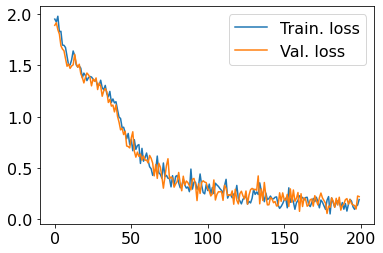

Should training continue? (press Enter)
Iteration 0/200: loss: -13.29 val_loss: -12.95 
Iteration 10/200: loss: -13.44 val_loss: -13.12 
Iteration 20/200: loss: -13.59 val_loss: -13.53 
Iteration 30/200: loss: -13.68 val_loss: -13.63 
Iteration 40/200: loss: -13.73 val_loss: -13.72 
Iteration 50/200: loss: -13.69 val_loss: -13.71 
Iteration 60/200: loss: -13.74 val_loss: -13.71 
Iteration 70/200: loss: -13.74 val_loss: -13.75 
Iteration 80/200: loss: -13.72 val_loss: -13.68 
Iteration 90/200: loss: -13.72 val_loss: -13.75 
Iteration 100/200: loss: -13.77 val_loss: -13.74 
Iteration 110/200: loss: -13.78 val_loss: -13.74 
Iteration 120/200: loss: -13.75 val_loss: -13.73 
Iteration 130/200: loss: -13.74 val_loss: -13.76 
Iteration 140/200: loss: -13.74 val_loss: -13.72 
Iteration 150/200: loss: -13.76 val_loss: -13.75 
Iteration 160/200: loss: -13.76 val_loss: -13.75 
Iteration 170/200: loss: -13.73 val_loss: -13.77 
Iteration 180/200: loss: -13.73 val_loss: -13.73 
Iteration 190/200: lo

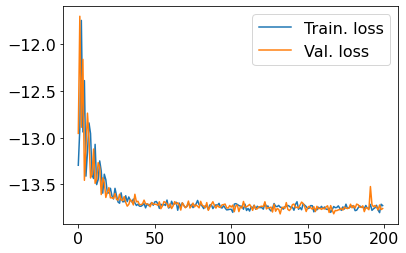

Should training continue? (press Enter)
Iteration 0/200: loss: -28.27 val_loss: -28.49 
Iteration 10/200: loss: -29.18 val_loss: -29.25 
Iteration 20/200: loss: -29.26 val_loss: -29.27 


In [ ]:
train_bg(training_shedule, "loss_with_aggressive_RC")

Estimator Standard Error:  0.10289213642351322


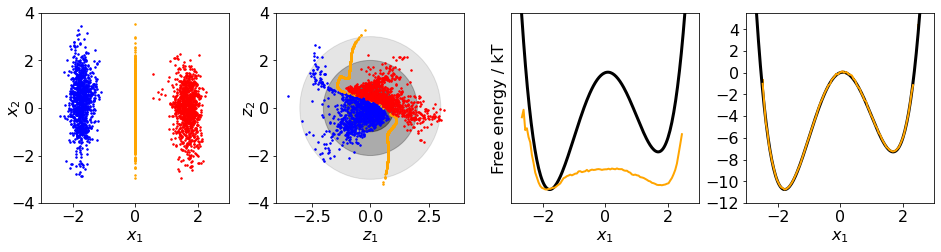

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [63]:
plot_network(bg, "trained_with_ML_KL_aggressive_RC.png")

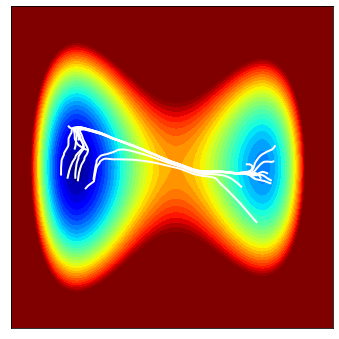

In [66]:
plot_latent_interpolation(bg, "latent_interpolation_with_agressive_RC.png")